# 10-test-stl.ipynb

This notebook performs the segmentation workflow adapted for the compressed F50 sand experiment and adds a step to convert the segmented voxels to tri-meshes to be saved as STLs.

# Import packages

In [103]:
# Set to False to use matplotlib.pyplot to view 2D images one at a time
use_napari = False
# Standard library imports
import math
from pathlib import Path
import sys
# Third-party imports
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
if use_napari:
    import napari
import numpy as np
from skimage import measure
from stl import mesh
# Local module imports
module_path = str(Path.cwd().parent)
if module_path not in sys.path:
    sys.path.append(module_path)
import segment
# Enable autoreload packages for changes made to local modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load 3D data

Passing `slice_crop`, `row_crop`, and `col_crop` to only load part of the dataset

In [2]:
# Load images as 3D array from a directory containing images
imgs = segment.load_images(
    Path(module_path) / r'data\SandComp4_18_22\NoComptiff',
    slice_crop=[75, 175], 
    row_crop=[450, 600], 
    col_crop=[100, 250],
    return_3d_array=True,
    convert_to_float=True,
    file_suffix='tiff'
)
print(f'Images loaded as 3D array: {imgs.shape}')

Images loaded as 3D array: (100, 150, 150)


In [3]:
# Show images with napari
if use_napari:
    # Open napari viewer
    viewer = napari.Viewer()
    viewer.add_image(imgs)

# Binarize data

In [4]:
imgs_binarized, thresh_vals = segment.binarize_multiotsu(imgs, n_otsu_classes=2)

# Segment Data

In [5]:
segment_dict = segment.watershed_segment(
    imgs_binarized, 
    min_peak_distance=7, 
    return_dict=True
)

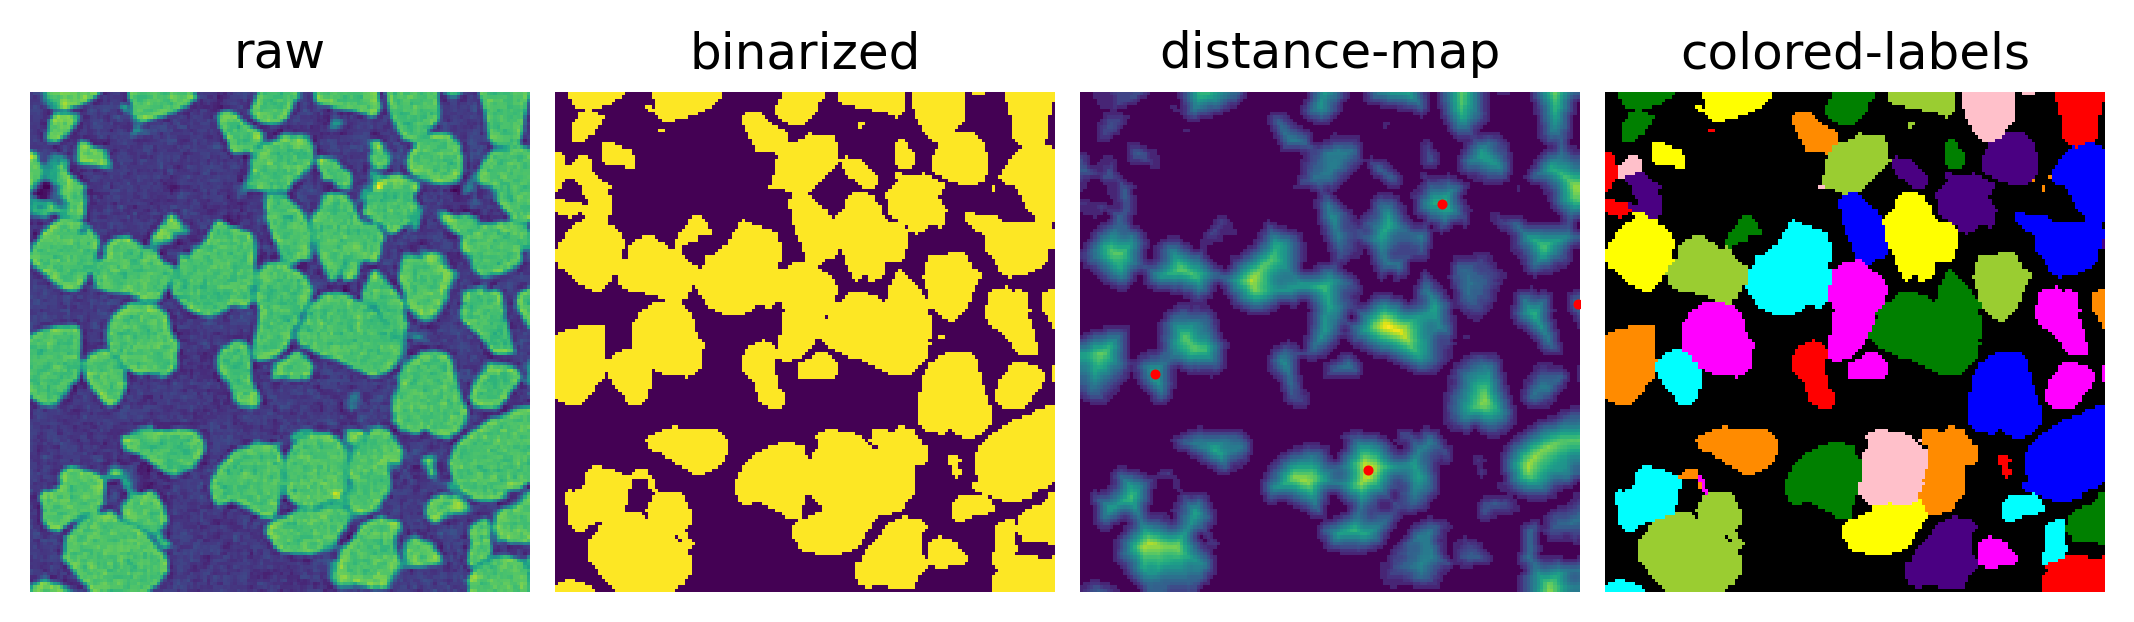

In [6]:
fig, axes = segment.plot_segment_steps(imgs, segment_dict, 55)
plt.show()

## Select sand grain

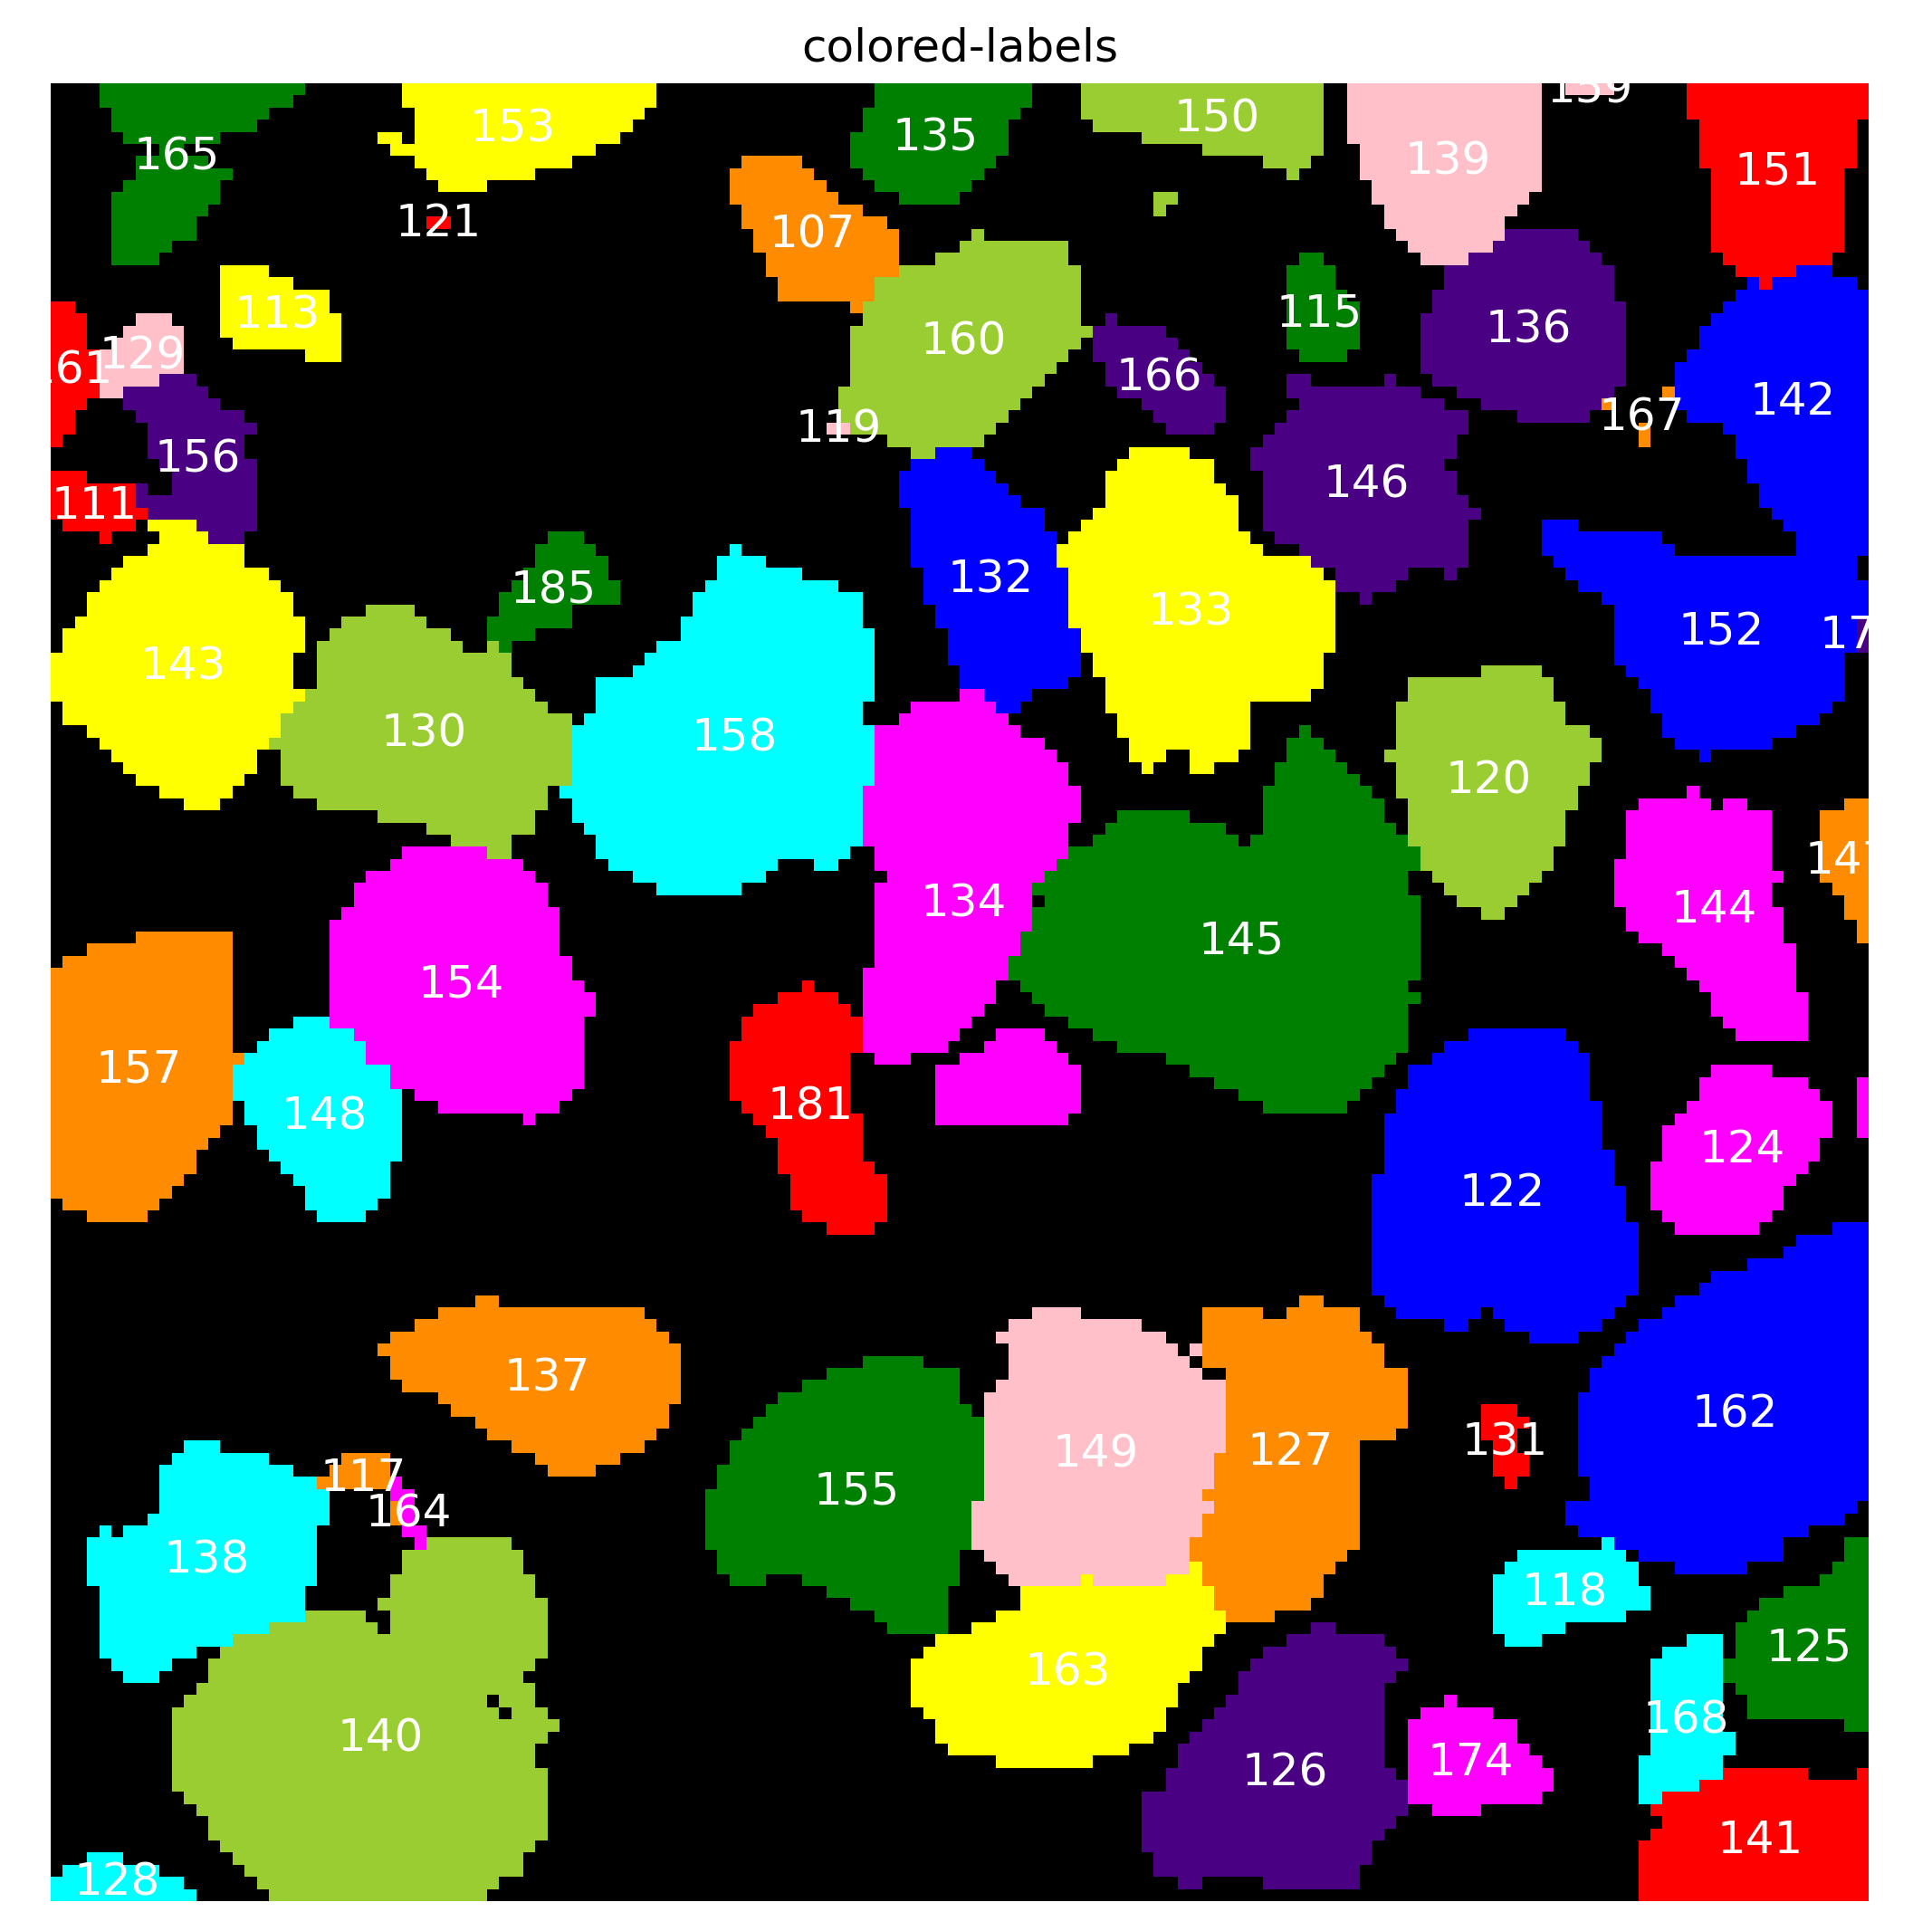

In [65]:
def show_particle_labels(
    segment_dict, 
    img_idx,
    label_color='white',
    label_bg_color=(0, 0, 0, 0),
    key='colored-labels',
    fig_w=7,
):
    n_axes_h = 1
    n_axes_w = 1
    img_w = segment_dict['integer-labels'].shape[2]
    img_h = segment_dict['integer-labels'].shape[1]
    title_buffer = .5
    fig_h = fig_w * (img_h / img_w) * (n_axes_h / n_axes_w) + title_buffer
    fig, ax = plt.subplots(
        n_axes_h, n_axes_w, dpi=300, figsize=(fig_w, fig_h), 
        constrained_layout=True, facecolor='white',
    )
    ax.imshow(
        segment_dict[key][img_idx, ...], interpolation='nearest'
    )
    ax.set_axis_off()
    ax.set_title(key)
    regions = measure.regionprops(segment_dict['integer-labels'][img_idx, ...])
    label_centroid_pairs = [(region.label, region.centroid) for region in regions]
    for label, centroid in label_centroid_pairs:
        ax.text(
            centroid[1], centroid[0], str(label), fontsize='large',
            color=label_color, backgroundcolor=label_bg_color, ha='center', 
            va='center'
        )
    return fig, ax
fig, ax = show_particle_labels(segment_dict, 55)
plt.show()

(47, 62, 22, 69, 86, 45)


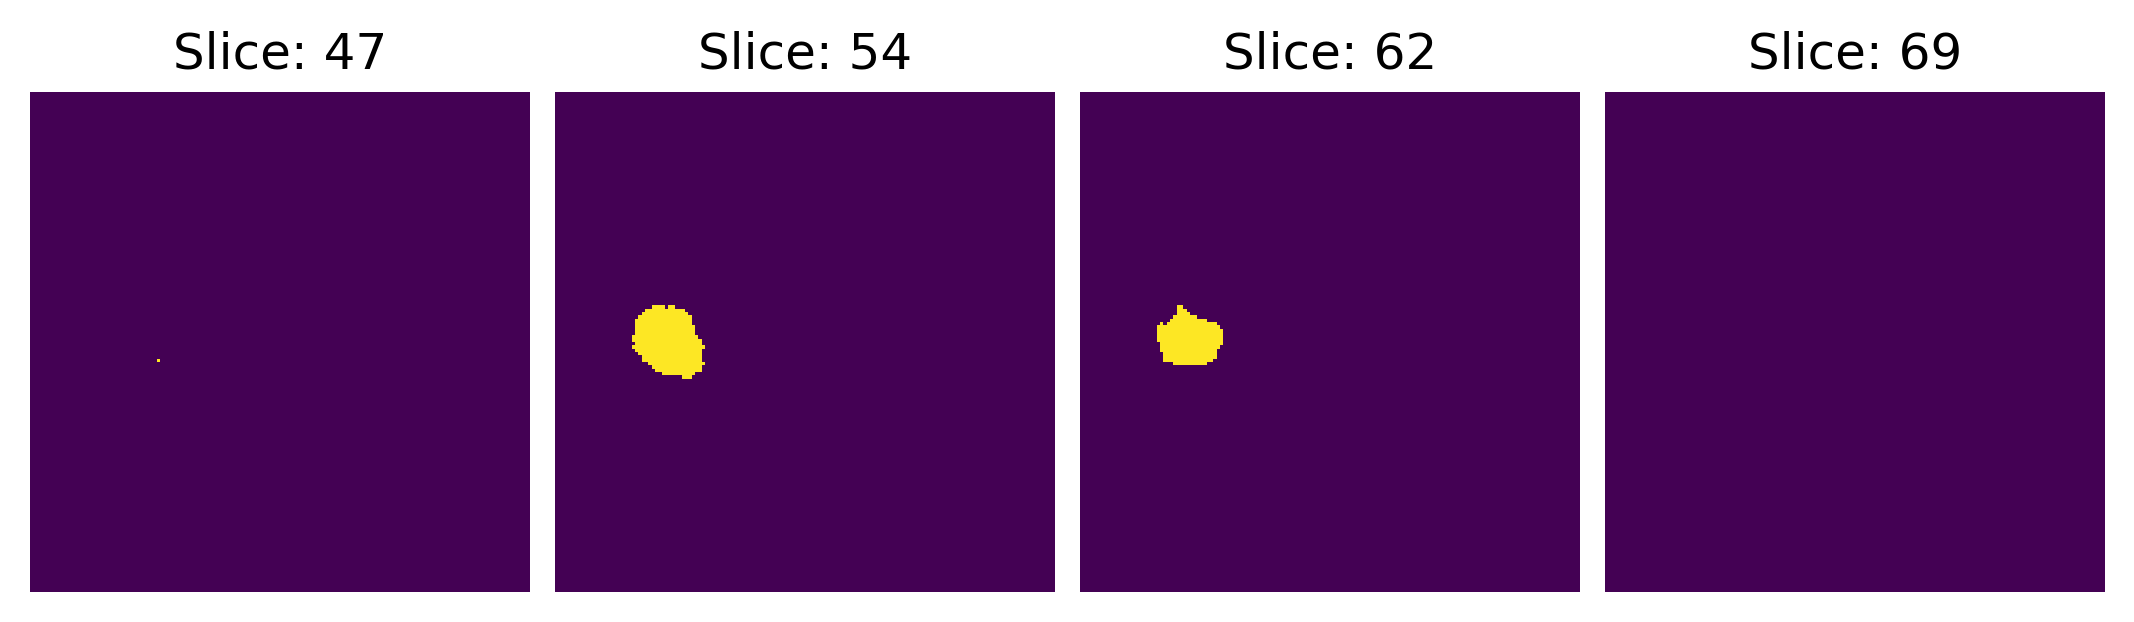

In [87]:
def isolate_particle(segment_dict, integer_label):
    imgs_single_particle = np.zeros_like(segment_dict['integer-labels'])
    imgs_single_particle[segment_dict['integer-labels'] == integer_label] = 1
    return imgs_single_particle

def plot_particle_slices(imgs_single_particle, n_slices=4, fig_w=7):
    # bounds: (min_slice, min_row, min_col, max_slice, max_row, max_col)
    bounds = measure.regionprops(imgs_single_particle)[0].bbox
    print(bounds)
    # bounds[0] and bounds[3] used for min_slice and max_slice respectively
    slices = [round(i) for i in np.linspace(bounds[0], bounds[3], n_slices)]
    n_axes_h = 1
    n_axes_w = n_slices
    img_w = imgs_single_particle.shape[2]
    img_h = imgs_single_particle.shape[1]
    title_buffer = .5
    fig_h = fig_w * (img_h / img_w) * (n_axes_h / n_axes_w) + title_buffer
    fig, axes = plt.subplots(
        n_axes_h, n_axes_w, dpi=300, figsize=(fig_w, fig_h), 
        constrained_layout=True, facecolor='white',
    )
    if not isinstance(axes, np.ndarray):
        ax = [axes]
    else:
        ax = axes.ravel()
    for i, slice_i in enumerate(slices):
        ax[i].imshow(imgs_single_particle[slice_i, ...], interpolation='nearest')
        ax[i].set_axis_off()
        ax[i].set_title(f'Slice: {slice_i}')
    return fig, ax

imgs_particle_154 = isolate_particle(segment_dict, 154)
fig, axes = plot_particle_slices(imgs_particle_154)
plt.show()

## Marching cubes algorithm

In [74]:
# Use marching cubes to obtain the surface mesh of these ellipsoids
verts, faces, normals, values = measure.marching_cubes(imgs_particle_154)

Visualize mesh with matplotlib 3D

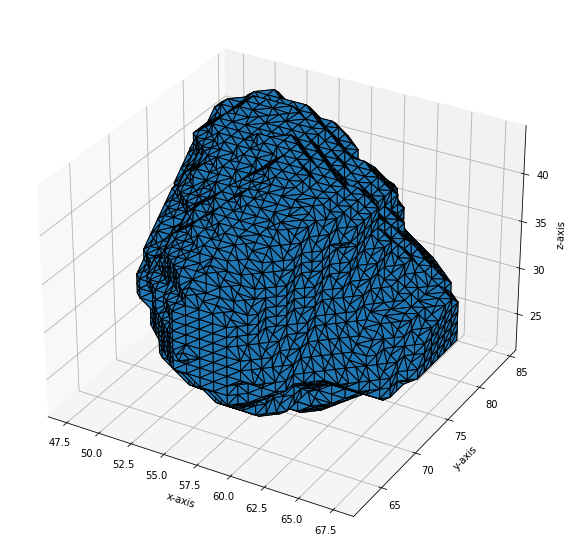

In [102]:

def plot_mesh_3D(verts, faces):
    # Display resulting triangular mesh using Matplotlib
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')
    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces])
    mesh.set_edgecolor('black')
    ax.add_collection3d(mesh)
    ax.set_xlabel("x-axis")
    ax.set_ylabel("y-axis")
    ax.set_zlabel("z-axis")
    ax.set_xlim(min(verts[:, 0]), max(verts[:, 0]))
    ax.set_ylim(min(verts[:, 1]), max(verts[:, 1]))
    ax.set_zlim(min(verts[:, 2]), max(verts[:, 2]))
    return fig, ax
fig, ax = plot_mesh_3D(verts, faces, imgs_particle_154)
plt.show()